In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/ashfakyeafi/pbd-load-history")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alvinb
Your Kaggle Key: ··········


100%|██████████| 673k/673k [00:00<00:00, 54.7MB/s]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.callbacks import  EarlyStopping


In [ ]:
df = pd.read_csv('/content/pbd-load-history/PDB_Load_History.csv')

In [ ]:
df.head()

,date,year,month,day,weekday,hour,demand,temperature
0,3/1/2003,2003,3,1,7,1,12863.0,29
1,3/1/2003,2003,3,1,7,2,12389.0,28
2,3/1/2003,2003,3,1,7,3,12155.0,29
3,3/1/2003,2003,3,1,7,4,12072.0,27
4,3/1/2003,2003,3,1,7,5,12160.0,29


In [ ]:
df.shape

(103776, 8)

In [ ]:
a = []
for i in df.date.unique():
    a.append(df[df.date==i].mean())

In [ ]:
df_new = pd.DataFrame(a)

In [ ]:
df_new['date'] = df.date.unique()

In [ ]:
df_new.set_index('date')

,year,month,day,weekday,hour,demand,temperature
date,,,,,,,
3/1/2003,2003.0,3.0,1.0,7.0,12.5,14216.875000,32.083333
3/2/2003,2003.0,3.0,2.0,1.0,12.5,13851.625000,34.458333
3/3/2003,2003.0,3.0,3.0,2.0,12.5,16348.875000,14.958333
3/4/2003,2003.0,3.0,4.0,3.0,12.5,16575.500000,18.791667
3/5/2003,2003.0,3.0,5.0,4.0,12.5,15391.875000,36.458333
...,...,...,...,...,...,...,...
12/27/2014,2014.0,12.0,27.0,7.0,12.5,12843.750000,40.416667
12/28/2014,2014.0,12.0,28.0,1.0,12.5,12779.208333,44.041667
12/29/2014,2014.0,12.0,29.0,2.0,12.5,14332.291667,34.125000


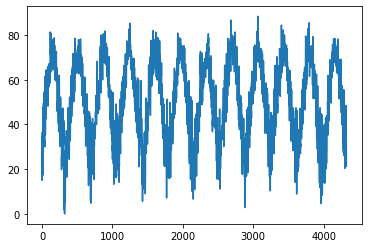

In [ ]:
df_new['temperature'].plot()

In [ ]:

def time_data(data, window):
  x = []
  y = []
  for i in range(len(data)-window-1):
    x.append(data[i:(i+window),0])
    y.append(data[i+window,0])
  return np.array(x),np.array(y)

In [ ]:
print("MAE harus dibawah "+str(df_new['temperature'].max()-df_new['temperature'].min()))

MAE harus dibawah 88.41666666666667


In [ ]:
df_temp = df_new['temperature']

In [ ]:
split = int(len(df_temp)*0.8)

train_value = df_temp[0:split]
test_value = df_temp[split:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler(feature_range=(0,1))

train_value = scale.fit_transform(np.array(train_value).reshape(-1,1))
test_value = scale.transform(np.array(test_value).reshape(-1,1))
train_value = np.array(train_value).reshape(-1,1)
test_value = np.array(test_value).reshape(-1,1)

In [ ]:
window = 100
x_train,y_train = time_data(train_value,window)
x_test,y_test = time_data(test_value,window)

x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(8 ,  return_sequences=True),input_shape=(100,1)),
  #tf.keras.layers.Dropout(0.2),
  
  # tf.keras.layers.LSTM(50,return_sequences = True),
  # tf.keras.layers.Dropout(0.2),
  
  # tf.keras.layers.LSTM(50,return_sequences = True),
  # tf.keras.layers.Dropout(0.2),

  tf.keras.layers.LSTM(10,return_sequences = False),

  tf.keras.layers.Dense(1),
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-04),metrics=['mae'],loss= tf.keras.losses.Huber())
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.1):
      print("\nMAE sudah dibawah 10%")
      self.model.stop_training = True
callbacks = myCallback()
# callbacks = EarlyStopping(
#     min_delta=0.00001,
#     patience=5,
#     restore_best_weights=True,
#     monitor ='val_mae',
# )

hist = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[callbacks],epochs=100,batch_size=50)

Epoch 1/100
68/68 [==============================] - 32s 101ms/step - loss: 0.1265 - mae: 0.4714 - val_loss: 0.0924 - val_mae: 0.3962
Epoch 2/100
68/68 [==============================] - 6s 86ms/step - loss: 0.0742 - mae: 0.3524 - val_loss: 0.0457 - val_mae: 0.2690
Epoch 3/100
68/68 [==============================] - 6s 84ms/step - loss: 0.0297 - mae: 0.2100 - val_loss: 0.0125 - val_mae: 0.1331
Epoch 4/100
68/68 [==============================] - 6s 83ms/step - loss: 0.0079 - mae: 0.1031 - val_loss: 0.0059 - val_mae: 0.0880
Epoch 5/100
68/68 [==============================] - 6s 84ms/step - loss: 0.0054 - mae: 0.0842 - val_loss: 0.0056 - val_mae: 0.0842

MAE sudah dibawah 10%


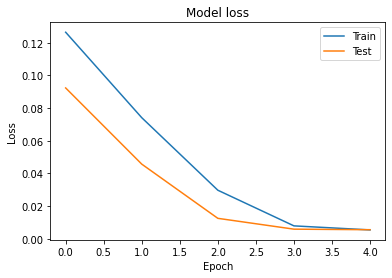

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper right')
plt.show()

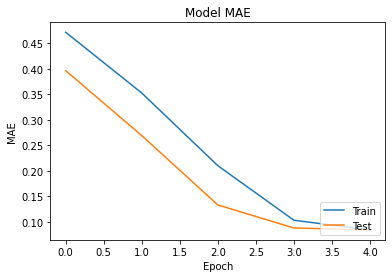

In [ ]:
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='lower right')
plt.show()

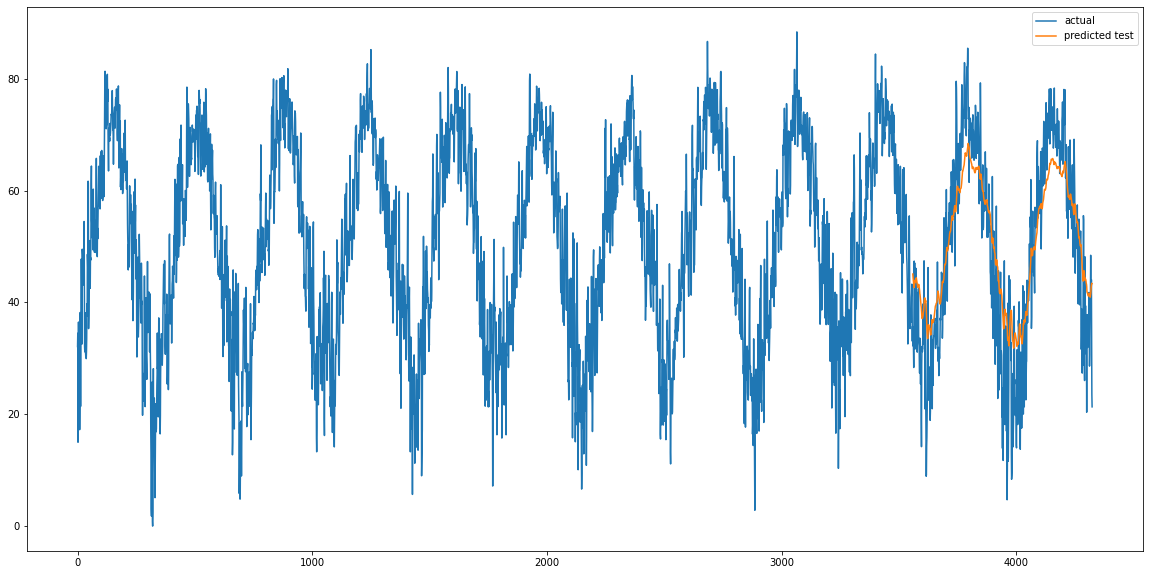

In [ ]:

pred_test = pred_train = model.predict(x_test)
pred_test = scale.inverse_transform(pred_test)



test_plot = np.empty_like(df_temp)
test_plot = test_plot.reshape(-1,1)
test_plot[:,:]=np.nan
test_plot[len(df_temp)-len(pred_test)-1:len(df_temp)-1,:] = pred_test

plt.figure(figsize=(20,10))
plt.plot(df_temp)

plt.plot(test_plot)
plt.legend(['actual','predicted test'])